# Env 

In [1]:
cd ..

/Users/svo6059/PycharmProjects/CISS_Project


## Imports 

In [2]:
from project.preprocessing.generator import glove_generator

In [14]:
from nltk import word_tokenize

In [3]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin

In [4]:
import json
import pandas as pd
from sklearn.decomposition import PCA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas
%load_ext autoreload
%autoreload 2

In [6]:
from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

embedder = GloVeEmbedder(load_path="data/models/glove.txt", 
                         pad_zero=False  # means whether to pad up to the longest sample in a batch
                    )

[nltk_data] Downloading package punkt to /Users/svo6059/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/svo6059/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /Users/svo6059/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /Users/svo6059/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
2019-06-26 20:00:08.324 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 52: [loading GloVe embeddings from `/Users/svo6059/PycharmProjects/CISS_Project/data/models/glove.txt`]
/usr/local/anaconda3/envs/pavlov/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://gi

## Functions 

### Generator 

In [7]:
import tensorflow as tf

### Sklearn 

class GloVeWord(TransformerMixin):
    def __init__(self, max_size=None):
        if max_size is None:
            self.fit_size = True
            self.max_size = None
        else:
            self.fit_size = True
            self.max_size = max_size
            self.max_size = max([len(x for x in X)])
            
    def fit(self, X, y):
        if type(X[0]) is not str:
            pass
        if self.fit_size:
            paxs
        
    def transform(self):
        

class AverageSentence(TransformerMixin):
    """
    Applies glove embeddings
    
    Parameters
    ----------
    method : string
        possible methods are 'concat' and 'average'
    """
    def __init__(self, embedding, method='concat'):
        self.method = method
        
    def fit(self, X, y=None):
        assert type(X[0]) is not str
        self.max_size = max([len(x for x in X)])
        return self
    def transform(self, X, y=None):
        assert type(X[0]) is not str
        emb = embedder(X)
        if self.method == 'concat':
            return emb.reshape(X.shape[0], -1)
        elif self.method == 'average':
            return emb.mean(axis=1)
        else:
            raise NotImplementedError
            


### Metrics 

## Data loading

In [11]:
train = pd.read_json('data/train.json')
dev = pd.read_json('data/dev.json')

In [16]:
%%time
train['sentence'] = train.sentence.apply(word_tokenize)
train['question'] = train.question.apply(word_tokenize)

CPU times: user 1min 53s, sys: 780 ms, total: 1min 54s
Wall time: 1min 55s


In [17]:
%%time
dev['sentence'] = dev.sentence.apply(word_tokenize)
dev['question'] = dev.question.apply(word_tokenize)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [12]:
print(train.shape)
print(dev.shape)

(457135, 5)
(54876, 5)


# Body

## Tokenize

(0, 70)

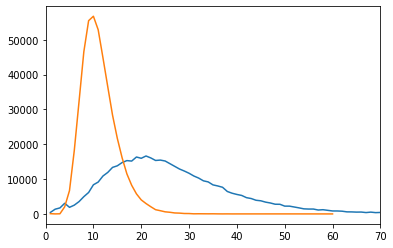

In [18]:
train.sentence.apply(len).value_counts().sort_index().plot()
train.question.apply(len).value_counts().sort_index().plot()
plt.xlim(0,70)

## Test generator

In [85]:
from sklearn.metrics import precision_score

In [ ]:
from keras_metrics import binary_f1_score, binary_precision

In [36]:
s = embedder(train.head(6).sentence)

### Shallow model

In [35]:
inp = tf.keras.layers.Input((200,))
x = tf.keras.layers.Dense(50, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall()])

#### Unbalanced results 

In [37]:
BATCH_SIZE = 128
epoch_steps = train.shape[0]//BATCH_SIZE
val_steps = dev.shape[0]//BATCH_SIZE
gen = glove_generator(train, BATCH_SIZE, embedder=embedder)

history = model.fit_generator(gen, steps_per_epoch=epoch_steps, epochs=10, 
                   validation_data = glove_generator(dev, BATCH_SIZE, embedder=embedder), 
                              validation_steps = val_steps, class_weights={0})

Epoch 1/10
3571/3571 [==============================] - 53s 15ms/step - loss: 0.4622 - acc: 0.8084 - precision_2: 0.3333 - recall_2: 5.7084e-05 - val_loss: 0.4715 - val_acc: 0.7918 - val_precision_2: 1.0000 - val_recall_2: 2.6293e-04
Epoch 2/10
3571/3571 [==============================] - 63s 18ms/step - loss: 0.4229 - acc: 0.8122 - precision_2: 0.6222 - recall_2: 0.0500 - val_loss: 0.4373 - val_acc: 0.8021 - val_precision_2: 0.6379 - val_recall_2: 0.1159
Epoch 3/10
3571/3571 [==============================] - 63s 18ms/step - loss: 0.4063 - acc: 0.8194 - precision_2: 0.6259 - recall_2: 0.1432 - val_loss: 0.4283 - val_acc: 0.8074 - val_precision_2: 0.6472 - val_recall_2: 0.1673
Epoch 4/10
3571/3571 [==============================] - 63s 18ms/step - loss: 0.3963 - acc: 0.8240 - precision_2: 0.6286 - recall_2: 0.2003 - val_loss: 0.4222 - val_acc: 0.8124 - val_precision_2: 0.6510 - val_recall_2: 0.2149
Epoch 5/10
3571/3571 [==============================] - 64s 18ms/step - loss: 0.3902 - a

In [38]:
res = pd.DataFrame(history.history).reset_index()
res = res.melt(id_vars = 'index')
res['val'] = res.variable.str.contains('val')
res['variable'] = res.variable.apply(lambda s: s[4:] if 'val' in s else s)

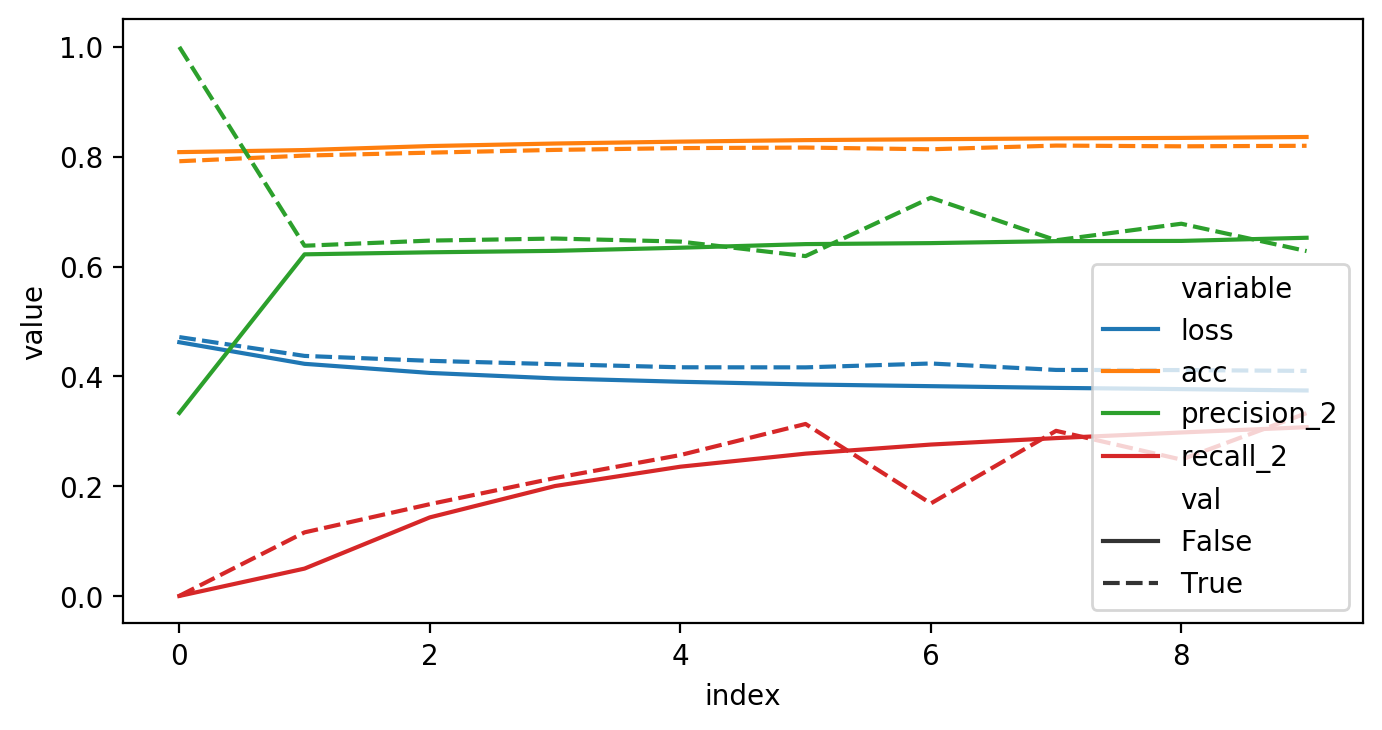

In [45]:
fig, ax = plt.subplots(figsize=(8,4), dpi=200)
sns.lineplot(x = 'index', y='value', hue='variable', style='val', data=res, ax=ax)

In [88]:
def confusion_matrix_generation(trained_model, dev_set, batch=128, normalize=False, threshold=.5):
    ypred = trained_model.predict_generator(glove_generator(dev_set, batch, embedder=embedder), steps = val_steps)
    true_gen = glove_generator(dev_set, batch, embedder=embedder, only_labels=True)
    ytrue = pd.concat([next(true_gen) for i in range(val_steps)]).values
    
    conf = confusion_matrix(ytrue, ypred>threshold)
    
    if normalize:
        return (conf.T/conf.sum(axis=1)).T
    else:
        return conf

In [87]:
from sklearn.metrics import confusion_matrix

In [89]:
%time mat = confusion_matrix_generation(model, dev, normalize=True)

CPU times: user 20.9 s, sys: 6.91 s, total: 27.8 s
Wall time: 4.58 s


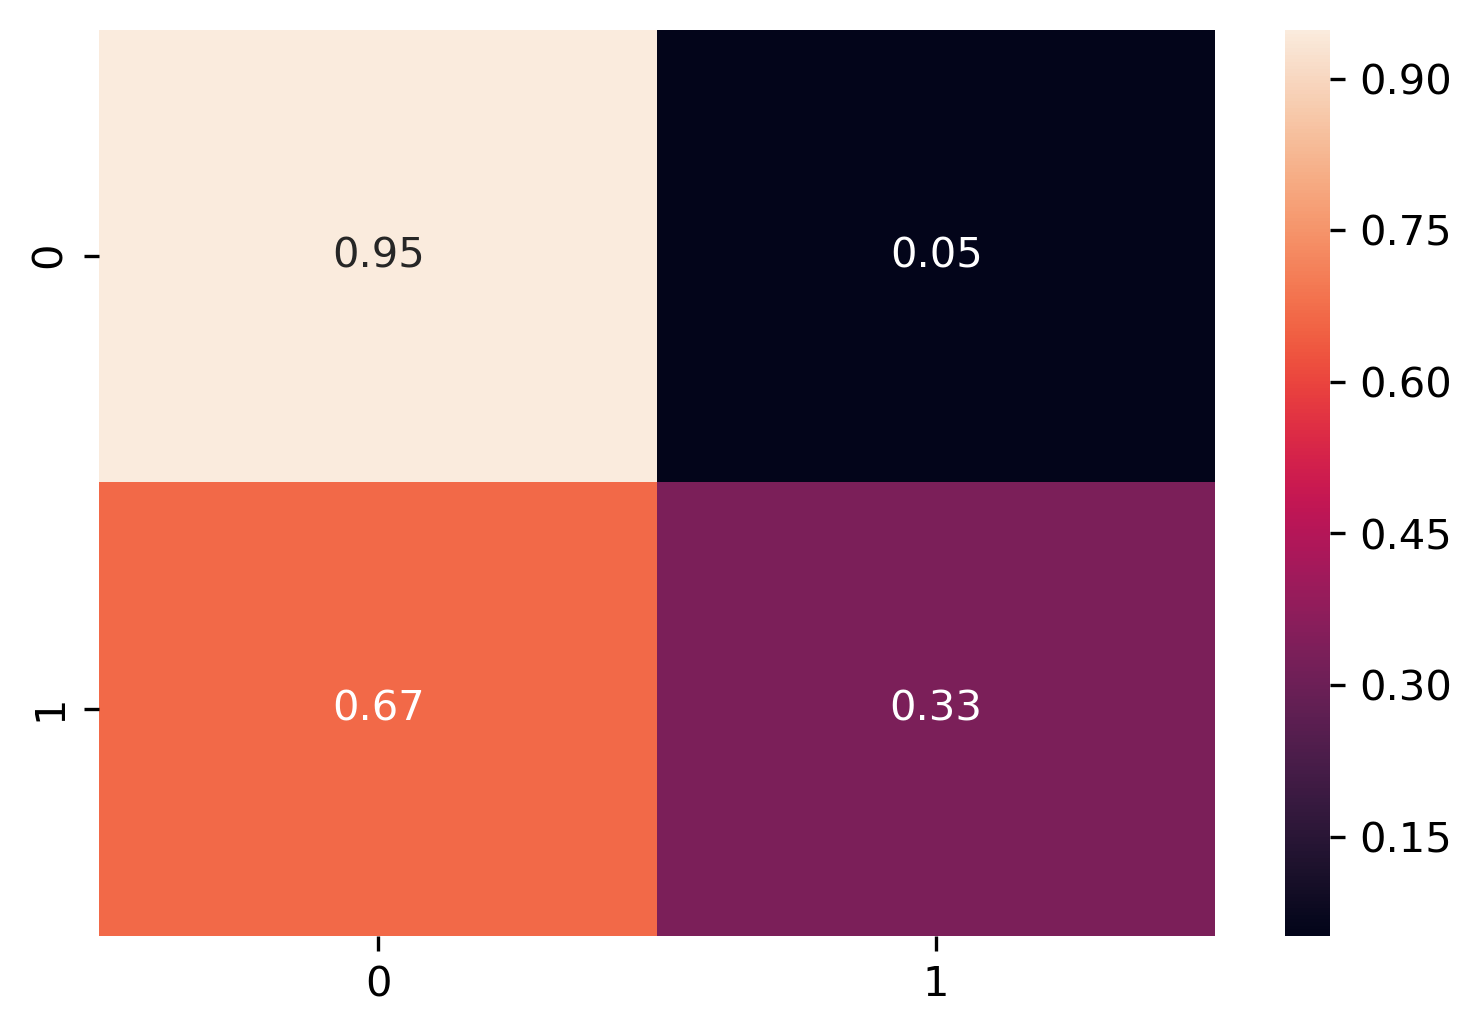

In [93]:
plt.figure(dpi=300)
sns.heatmap(mat, annot=True, fmt='.2f')

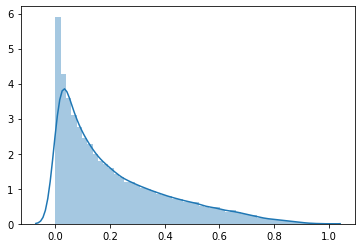

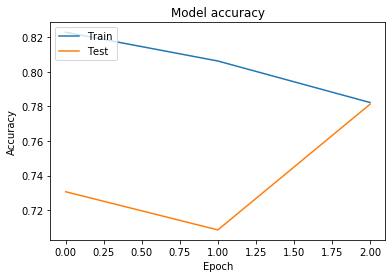

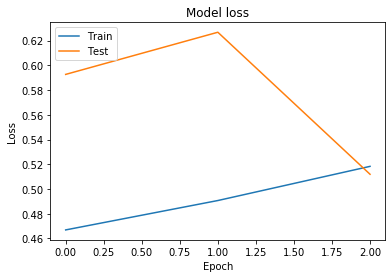

In [34]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [33]:
history.history

{'loss': [0.46689446606266666, 0.49065639771206276, 0.5182865005983434],
 'acc': [0.8228433, 0.806228, 0.78224033],
 'precision_1': [0.10489511, 0.0, 0.0],
 'recall_1': [0.01002004, 0.0, 0.0],
 'val_loss': [0.5926421197021708, 0.6267272882601794, 0.5118879956357619],
 'val_acc': [0.7306985, 0.7086397, 0.78125],
 'val_precision_1': [0.0, 0.0, 0.0],
 'val_recall_1': [0.0, 0.0, 0.0]}

#### Balanced data 

In [ ]:
train[train.label==1]